# The moving average model: MA(q)

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
plt.rcParams["figure.figsize"] = (9,6)



## Simulate a MA(1) process 

In [6]:
ma1 = np.array([1, 0.9])
ar1 = np.array([1,0])

ma1_process = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [29]:
ar1

array([1, 0])

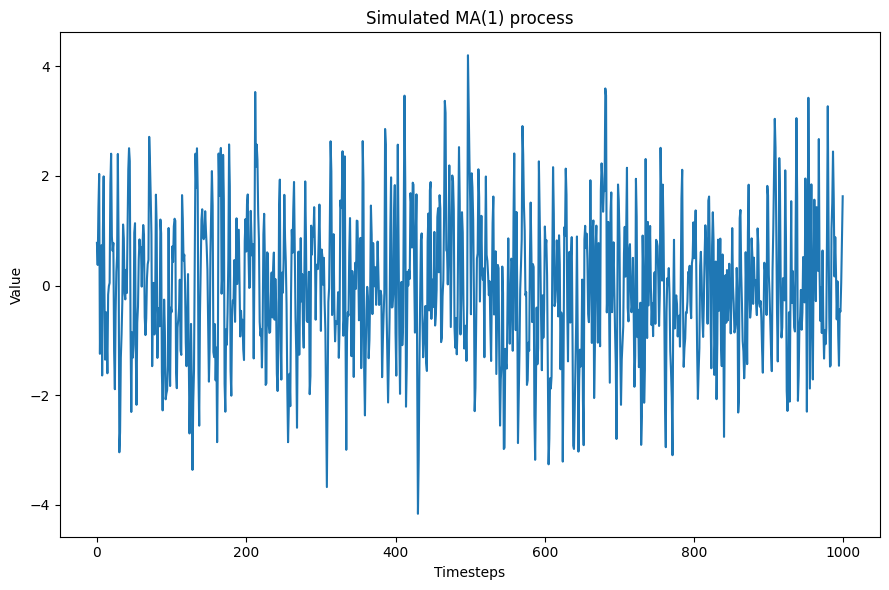

In [7]:
fig, ax = plt.subplots()

ax.plot(ma1_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.title('Simulated MA(1) process')

plt.tight_layout()

In [8]:
ADF_result = adfuller(ma1_process)

print(f'ADF statistic: {ADF_result[0]}')
print(f'p-values: {ADF_result[1]}')

ADF statistic: -6.553843050237062
p-values: 8.715629792958696e-09


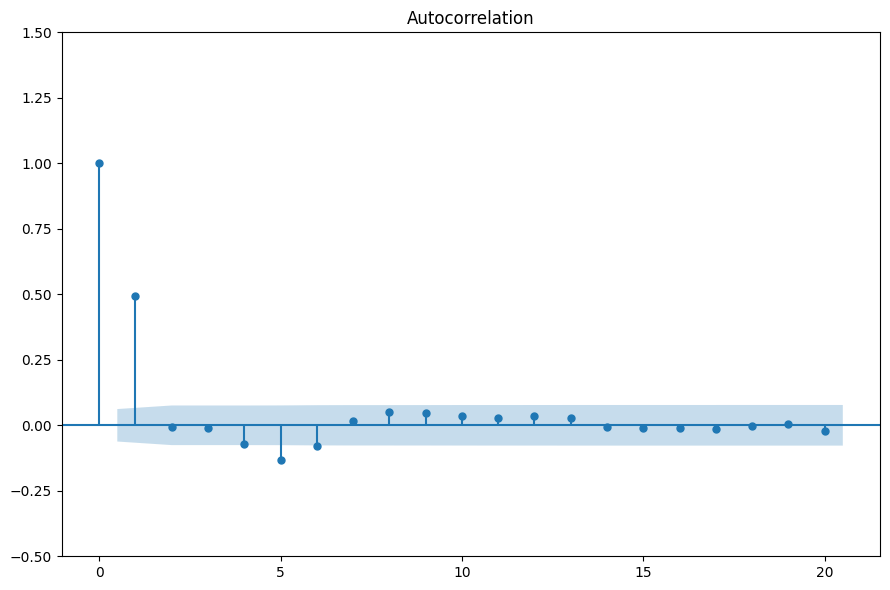

In [9]:
plot_acf(ma1_process, lags=20);

plt.ylim(-0.5, 1.5)
plt.tight_layout()

## Forecasting with the MA(q) model 

In [10]:
df = pd.read_csv('data/simulated_MA3.csv')
print(df.shape)
df.head()

(1000, 1)


,value
0,50.000000
1,50.679213
2,51.771045
3,50.959927
4,52.162826


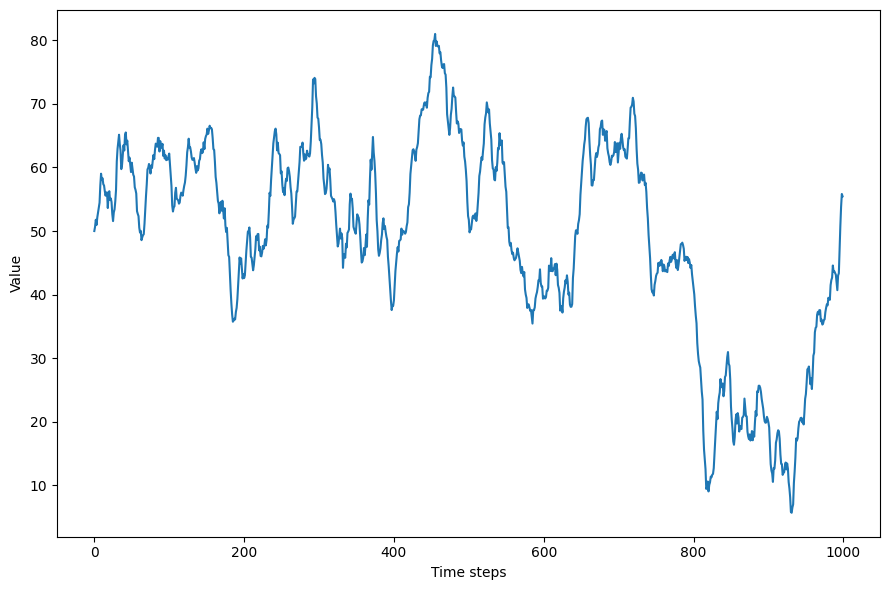

In [11]:
fig, ax = plt.subplots()

ax.plot(df['value'])
ax.set_xlabel('Time steps')
ax.set_ylabel('Value')

plt.tight_layout()

### Test for stationarity 

In [12]:
# dickey  fuller
ADF_result = adfuller(df['value'])

print(f'ADF statistic: {ADF_result[0]}')
print(f'p-values: {ADF_result[1]}')

ADF statistic: -2.4346611743907176
p-values: 0.13219152456766425


In [13]:
# apply transformation
series_diff = np.diff(df['value'], n=1)

In [14]:
# dickey  fuller
ADF_result = adfuller(series_diff)

print(f'ADF statistic: {ADF_result[0]}')
print(f'p-values: {ADF_result[1]}')

ADF statistic: -6.149220026451249
p-values: 7.63417127123803e-08


### Plot ACF 

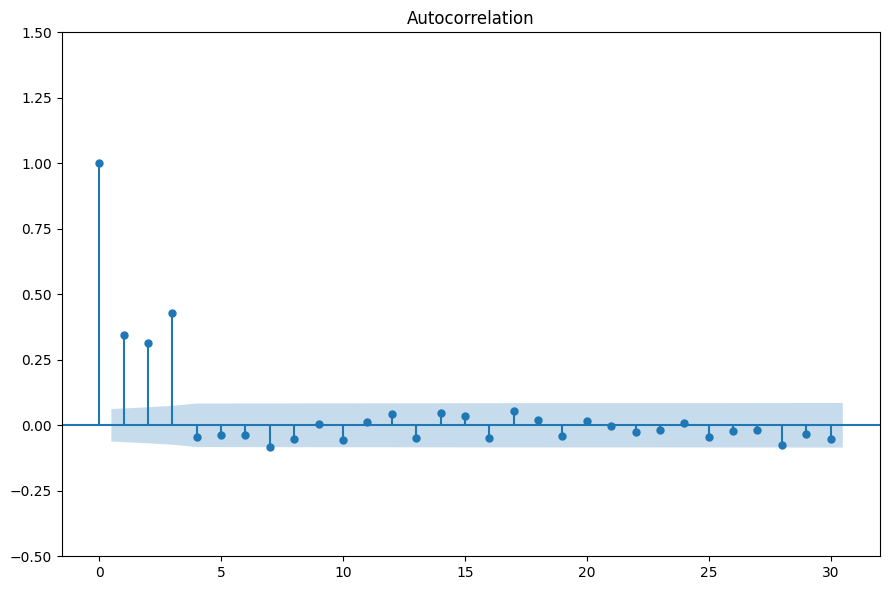

In [15]:
plot_acf(series_diff, lags=30)

plt.ylim(-0.5, 1.5)
plt.tight_layout()

In [16]:
# Split into training ans test set
df_diff = pd.DataFrame({'value': series_diff})

train = df_diff[:-100]
test = df_diff[-100:]

print(train.shape, test.shape)

(899, 1) (100, 1)


In [17]:
df_diff.head()

,value
0,0.679213
1,1.091831
2,-0.811117
3,1.202898
4,0.767791


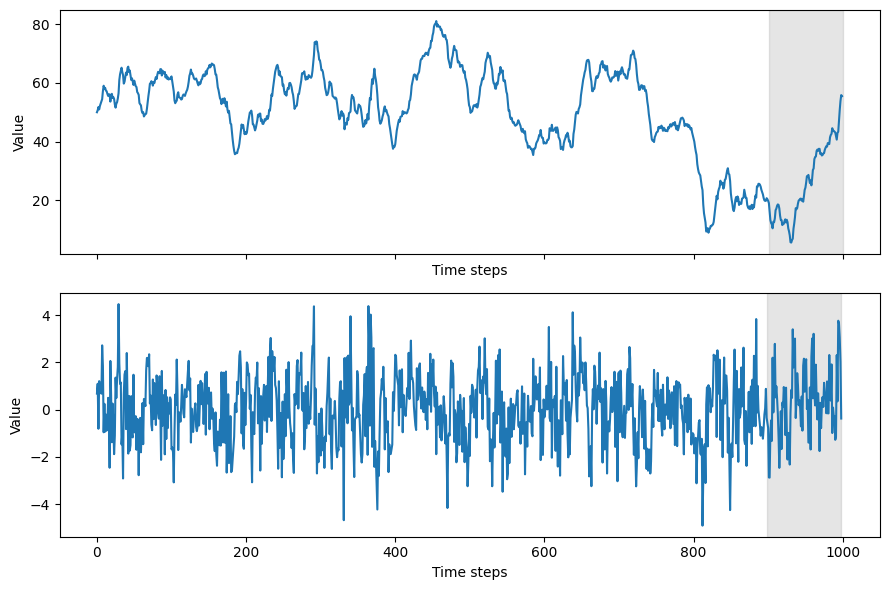

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['value'])
ax1.set_xlabel('Time steps')
ax1.set_ylabel('Value')
ax1.axvspan(901, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['value'])
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Value')
ax2.axvspan(899, 998, color='#808080', alpha=0.2)

plt.tight_layout()

In [23]:
# function for rolling predictions
def rolling_predictions(df_diff, last_train_value, train_len, horizon, window, method):

    TOTAL_LEN = train_len + horizon

    if method == 'mean':

        pred_mean = []

        for i in range(train_len, TOTAL_LEN, window):

            mean = np.mean(df_diff[:i].values)

            pred_mean.extend(mean for _ in range(window))
        
        pred_mean = np.concatenate((last_train_value, pred_mean))
        pred_mean = pred_mean.cumsum()

        return pred_mean[:100]
    
    elif method == 'last':

        pred_last_value = []

        for i in range(train_len, TOTAL_LEN, window):

            last_value = df_diff[:i].iloc[-1].values[0]

            pred_last_value.extend(last_value for _ in range(window))
        
        pred_last_value = np.concatenate((last_train_value, pred_last_value))
        pred_last_value = pred_last_value.cumsum()

        return pred_last_value[:100]
    
    elif method == 'MA':

        pred_MA = []

        for i in range(train_len, TOTAL_LEN, window):

            model = SARIMAX(df_diff[:i], order=(0,0,3))
            res = model.fit(dsip= False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]

            pred_MA.extend(oos_pred)
        
        pred_MA = np.concatenate((last_train_value, pred_MA))
        pred_MA = pred_MA.cumsum()

        return pred_MA[:100]

In [24]:
# create dataframe for predictions
pred_df = df[-100:].copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
LAST_TRAIN_VALUE = df.iloc[899]

windows = [1,2, 5, 10]

for window in windows:

    pred_mean = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'mean')
    pred_last = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'last')
    pred_MA = rolling_predictions(df_diff, LAST_TRAIN_VALUE, TRAIN_LEN, HORIZON, window, 'MA')

    pred_df[f'pred_mean_{window}'] = pred_mean
    pred_df[f'pred_last_{window}'] = pred_last
    pred_df[f'pred_MA_{window}'] = pred_MA

pred_df.head()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48196D+00    |proj g|=  8.27840D-02

At iterate    5    f=  1.45648D+00    |proj g|=  2.76075D-01

At iterate   10    f=  1.45194D+00    |proj g|=  1.17702D-01

At iterate   15    f=  1.45032D+00    |proj g|=  4.53130D-02

At iterate   20    f=  1.45004D+00    |proj g|=  4.49727D-02

At iterate   25    f=  1.45003D+00    |proj g|=  5.22905D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   5.229D-04   1.450D+00
  F =   1.4500252365209412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48205D+00    |proj g|=  8.21864D-02

At iterate    5    f=  1.45717D+00    |proj g|=  2.65825D-01

At iterate   10    f=  1.45278D+00    |proj g|=  1.32559D-01

At iterate   15    f=  1.45117D+00    |proj g|=  5.34186D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   6.364D-04   1.451D+00
  F =   1.4508604025745651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48170D+00    |proj g|=  8.15269D-02

At iterate    5    f=  1.45685D+00    |proj g|=  2.77889D-01

At iterate   10    f=  1.45227D+00    |proj g|=  6.68011D-02

At iterate   15    f=  1.45065D+00    |proj g|=  4.87957D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.45043D+00    |proj g|=  1.38880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   1.389D-03   1.450D+00
  F =   1.4504278668939146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48214D+00    |proj g|=  7.97177D-02

At iterate    5    f=  1.45667D+00    |proj g|=  2.54586D-01

At iterate   10    f=  1.45216D+00    |proj g|=  6.64845D-02

At iter

 This problem is unconstrained.


At iterate   25    f=  1.45053D+00    |proj g|=  4.91619D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     42      1     0     0   4.916D-04   1.451D+00
  F =   1.4505314797165507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48204D+00    |proj g|=  8.05466D-02

At iterate    5    f=  1.45585D+00    |proj g|=  1.50425D-01

At iterate   10    f=  1.45294D+00    |proj g|=  4.78846D-02

At itera


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.45057D+00    |proj g|=  9.35312D-03

At iterate   25    f=  1.45050D+00    |proj g|=  8.16733D-03

At iterate   30    f=  1.45050D+00    |proj g|=  1.42089D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     48      1     0     0   1.421D-05   1.450D+00
  F =   1.4504991187841696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48187D+00    |proj g|=  8.03030D-02

At iterate    5    f=  1.45572D+00    |proj g|=  2.09169D-01

At iterate   10    f=  1.45194D+00    |proj g|=  1.53110D-01

At iterate   15    f=  1.45030D+00    |proj g|=  3.01943D-02

At iterate   20    f=  1.45000D+00    |proj g|=  2.51757D-02

At iterate   25    f=  1.44995D+00    |proj g|=  3.68242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     48      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     55      2     0     0   1.793D-04   1.450D+00
  F =   1.4498121069552699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48218D+00    |proj g|=  7.96112D-02

At iterate    5    f=  1.45602D+00    |proj g|=  2.70165D-01

At iterate   10    f=  1.45142D+00    |proj g|=  8.03411D-02

At iterate   15    f=  1.44979D+00    |proj g|=  2.81644D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.45088D+00    |proj g|=  1.59958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   1.600D-04   1.451D+00
  F =   1.4508812239461073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48316D+00    |proj g|=  7.93435D-02

At iterate    5    f=  1.45707D+00    |proj g|=  2.40906D-01

At iterate   10    f=  1.45273D+00    |proj g|=  3.38216D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     55      2     0     0   7.800D-06   1.451D+00
  F =   1.4509012139698463     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48366D+00    |proj g|=  7.94063D-02

At iterate    5    f=  1.45754D+00    |proj g|=  2.50458D-01

At iterate   10    f=  1.45314D+00    |proj g|=  6.27980D-02

At iterate   15    f=  1.45166D+00    |proj g|=  4.38474D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  1.45160D+00    |proj g|=  6.52111D-03

At iterate   25    f=  1.45159D+00    |proj g|=  4.42253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     53      2     0     0   4.423D-04   1.452D+00
  F =   1.4515932174897510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48363D+00    |proj g|=  8.03709D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.45745D+00    |proj g|=  2.43704D-01

At iterate   10    f=  1.45304D+00    |proj g|=  1.13559D-02

At iterate   15    f=  1.45152D+00    |proj g|=  5.32086D-02

At iterate   20    f=  1.45121D+00    |proj g|=  2.55260D-02

At iterate   25    f=  1.45119D+00    |proj g|=  4.57298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   4.573D-04   1.451D+00
  F =   1.4511901970764089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.45290D+00    |proj g|=  7.65454D-02

At iterate   15    f=  1.45134D+00    |proj g|=  1.92344D-02

At iterate   20    f=  1.45106D+00    |proj g|=  7.63778D-03

At iterate   25    f=  1.45101D+00    |proj g|=  5.39674D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     55      2     0     0   2.336D-05   1.451D+00
  F =   1.4510083699874363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48287D+00    |proj g|=  7.99489D-02

At iterate    5    f=  1.45698D+00    |proj g|=  2.51048D-01

At iterate   10    f=  1.45245D+00    |proj g|=  4.64394D-02

At iterate   15    f=  1.45098D+00    |proj g|=  5.89175D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48234D+00    |proj g|=  7.99077D-02

At iterate    5    f=  1.45649D+00    |proj g|=  2.54885D-01

At iterate   10    f=  1.45190D+00    |proj g|=  7.65218D-02

At iterate   15    f=  1.45042D+00    |proj g|=  1.44715D-02

At iterate   20    f=  1.45016D+00    |proj g|=  2.69805D-02

At iterate   25    f=  1.45012D+00    |proj g|=  6.50220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     49      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44958D+00    |proj g|=  3.61306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     44      1     0     0   3.613D-04   1.450D+00
  F =   1.4495797591069965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48307D+00    |proj g|=  8.10465D-02

At iterate    5    f=  1.45680D+00    |proj g|=  2.03547D-01

At iterate   10    f=  1.45302D+00    |proj g|=  4.63642D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   4.618D-04   1.451D+00
  F =   1.4507709328077505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48274D+00    |proj g|=  8.13014D-02

At iterate    5    f=  1.45626D+00    |proj g|=  1.59732D-01

At iterate   10    f=  1.45317D+00    |proj g|=  4.60446D-02

At iterate   15    f=  1.45126D+00    |proj g|=  8.10544D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     51      1     0     0   3.226D-04   1.451D+00
  F =   1.4505663775621438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48315D+00    |proj g|=  8.05484D-02

At iterate    5    f=  1.45646D+00    |proj g|=  1.86102D-01

At iterate   10    f=  1.45290D+00    |proj g|=  8.65282D-02

At iterate   15    f=  1.45105D+00    |proj g|=  4.84389D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   25    f=  1.45056D+00    |proj g|=  2.25103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     42      1     0     0   3.280D-04   1.451D+00
  F =   1.4505649451156402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48256D+00    |proj g|=  8.11478D-02

At iterate    5    f=  1.45599D+00    |proj g|=  1.98005D-01

At iterate   10    f=  1.45235D+00    |proj g|=  3.63752D-02

At itera

 This problem is unconstrained.



At iterate   20    f=  1.45005D+00    |proj g|=  2.90252D-02

At iterate   25    f=  1.45002D+00    |proj g|=  7.40894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   3.997D-04   1.450D+00
  F =   1.4500170968264263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48216D+00    |proj g|=  8.10367D-02

At iterate    5    f=  1.45566D+00    |proj g|=  2.09438D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.44968D+00    |proj g|=  1.63244D-02

At iterate   25    f=  1.44964D+00    |proj g|=  8.87016D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   6.419D-04   1.450D+00
  F =   1.4496353456118651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48189D+00    |proj g|=  8.08615D-02

At iterate    5    f=  1.45530D+00    |proj g|=  1.89760D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     51      1     0     0   4.542D-04   1.449D+00
  F =   1.4494958012479953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48219D+00    |proj g|=  8.10210D-02

At iterate    5    f=  1.45527D+00    |proj g|=  1.91721D-01

At iterate   10    f=  1.45177D+00    |proj g|=  3.73561D-02

At iterate   15    f=  1.44986D+00    |proj g|=  5.72121D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.44932D+00    |proj g|=  2.25510D-02

At iterate   20    f=  1.44892D+00    |proj g|=  2.40880D-02

At iterate   25    f=  1.44888D+00    |proj g|=  1.30988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     50      1     0     0   1.310D-03   1.449D+00
  F =   1.4488848986477452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48170D+00    |proj g|=  8.05794D-02

At iterate    5    f=  1.45474D+00    |proj g|=  2.08329D-01

At iterate   10    f=  1.45090D+00    |proj g|=  4.28914D-02

At iterate   15    f=  1.44910D+00    |proj g|=  8.06455D-02

At iterate   20    f=  1.44868D+00    |proj g|=  2.07620D-02

At iterate   25    f=  1.44863D+00    |proj g|=  3.25984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     57      2     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48123D+00    |proj g|=  8.09014D-02

At iterate    5    f=  1.45452D+00    |proj g|=  2.41659D-01

At iterate   10    f=  1.45002D+00    |proj g|=  2.58651D-02

At iterate   15    f=  1.44845D+00    |proj g|=  2.03319D-02

At iterate   20    f=  1.44813D+00    |proj g|=  4.57945D-02

At iterate   25    f=  1.44811D+00    |proj g|=  2.58999D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     68      2     0     0   6.194D-05   1.448D+00
  F =   1.4481120810035100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48084D+00    |proj g|=  8.07418D-02

At iterate    5    f=  1.45423D+00    |proj g|=  2.43315D-01

At iterate   10    f=  1.44972D+00    |proj g|=  1.19059D-02

At iterate   15    f=  1.44817D+00    |proj g|=  5.47258D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44784D+00    |proj g|=  3.18567D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     48      1     0     0   3.186D-04   1.448D+00
  F =   1.4478399397256605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48096D+00    |proj g|=  8.05813D-02

At iterate    5    f=  1.45460D+00    |proj g|=  2.45326D-01

At iterate   10    f=  1.45011D+00    |proj g|=  9.90349D-03

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44787D+00    |proj g|=  2.33236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     50      1     0     0   2.332D-04   1.448D+00
  F =   1.4478705197458452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48007D+00    |proj g|=  8.09249D-02

At iterate    5    f=  1.45337D+00    |proj g|=  2.10738D-01

At iterate   10    f=  1.44947D+00    |proj g|=  5.18085D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   25    f=  1.44733D+00    |proj g|=  1.23606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   9.900D-04   1.447D+00
  F =   1.4473314434691114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47979D+00    |proj g|=  8.14657D-02

At iterate    5    f=  1.45303D+00    |proj g|=  1.76063D-01

At iterate   10    f=  1.44974D+00    |proj g|=  4.19613D-02

At itera

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     66      2     0     0   5.943D-05   1.447D+00
  F =   1.4472121333823653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47964D+00    |proj g|=  8.12707D-02

At iterate    5    f=  1.45287D+00    |proj g|=  2.01660D-01

At iterate   10    f=  1.44916D+00    |proj g|=  4.12904D-02

At iterate   15    f=  1.44729D+00    |proj g|=  5.61105D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44695D+00    |proj g|=  6.60093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   8.383D-06   1.447D+00
  F =   1.4469525294777639     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47980D+00    |proj g|=  8.09865D-02

At iterate    5    f=  1.45292D+00    |proj g|=  2.11475D-01


 This problem is unconstrained.



At iterate   10    f=  1.44902D+00    |proj g|=  1.96917D-01

At iterate   15    f=  1.44717D+00    |proj g|=  3.05236D-03

At iterate   20    f=  1.44675D+00    |proj g|=  1.93632D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44671D+00    |proj g|=  7.33920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     47      1     0     0   7.339D-04   1.447D+00
  F =   1.4467058277168749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48143D+00    |proj g|=  8.24317D-02

At iterate    5    f=  1.45431D+00    |proj g|=  1.38818D-01

At iterate   10    f=  1.45122D+00    |proj g|=  6.89546D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.44907D+00    |proj g|=  4.62423D-02

At iterate   20    f=  1.44826D+00    |proj g|=  1.21051D-02

At iterate   25    f=  1.44820D+00    |proj g|=  3.86704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   3.802D-04   1.448D+00
  F =   1.4481962822518115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48048D+00    |proj g|=  8.33059D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.44865D+00    |proj g|=  4.65867D-02

At iterate   20    f=  1.44793D+00    |proj g|=  6.49915D-02

At iterate   25    f=  1.44786D+00    |proj g|=  5.44946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   6.997D-04   1.448D+00
  F =   1.4478553426328853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48012D+00    |proj g|=  8.43608D-02


 This problem is unconstrained.



At iterate    5    f=  1.45333D+00    |proj g|=  6.49646D-02

At iterate   10    f=  1.44994D+00    |proj g|=  9.11662D-02

At iterate   15    f=  1.44823D+00    |proj g|=  6.21595D-02

At iterate   20    f=  1.44778D+00    |proj g|=  3.33412D-02

At iterate   25    f=  1.44777D+00    |proj g|=  1.99925D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   1.601D-03   1.448D+00
  F =   1.4477680384460196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


At iterate   20    f=  1.44759D+00    |proj g|=  2.06605D-02

At iterate   25    f=  1.44756D+00    |proj g|=  7.73138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   6.465D-04   1.448D+00
  F =   1.4475597665903794     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47982D+00    |proj g|=  8.39675D-02

At iterate    5    f=  1.45272D+00    |proj g|=  9.28294D-02

At itera

 This problem is unconstrained.



At iterate   20    f=  1.44712D+00    |proj g|=  1.74931D-02

At iterate   25    f=  1.44707D+00    |proj g|=  1.78714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   1.787D-03   1.447D+00
  F =   1.4470716082570165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47981D+00    |proj g|=  8.38608D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45285D+00    |proj g|=  8.19822D-02

At iterate   10    f=  1.44956D+00    |proj g|=  7.95556D-02

At iterate   15    f=  1.44768D+00    |proj g|=  8.76301D-02

At iterate   20    f=  1.44722D+00    |proj g|=  1.75373D-02

At iterate   25    f=  1.44719D+00    |proj g|=  6.32132D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   5.162D-04   1.447D+00
  F =   1.4471922807458328     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.45361D+00    |proj g|=  8.59112D-02

At iterate   10    f=  1.45005D+00    |proj g|=  8.00389D-02

At iterate   15    f=  1.44845D+00    |proj g|=  7.46394D-02

At iterate   20    f=  1.44797D+00    |proj g|=  1.90818D-02

At iterate   25    f=  1.44790D+00    |proj g|=  5.38613D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     47      1     0     0   8.697D-04   1.448D+00
  F =   1.4479043022135407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47995D+00    |proj g|=  8.27746D-02

At iterate    5    f=  1.45314D+00    |proj g|=  7.36613D-02

At iterate   10    f=  1.44959D+00    |proj g|=  8.47465D-02

At iterate   15    f=  1.44805D+00    |proj g|=  5.12989D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   1.423D-03   1.447D+00
  F =   1.4474527745304619     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48010D+00    |proj g|=  8.25181D-02

At iterate    5    f=  1.45326D+00    |proj g|=  8.80697D-02

At iterate   10    f=  1.44985D+00    |proj g|=  7.49534D-02

At iterate   15    f=  1.44811D+00    |proj g|=  8.35553D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44747D+00    |proj g|=  2.58450D-02

At iterate   25    f=  1.44741D+00    |proj g|=  2.69079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     49      1     0     0   7.567D-05   1.447D+00
  F =   1.4474118342861260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47968D+00    |proj g|=  8.28319D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45267D+00    |proj g|=  1.16931D-01

At iterate   10    f=  1.44942D+00    |proj g|=  6.96996D-02

At iterate   15    f=  1.44777D+00    |proj g|=  4.53940D-02

At iterate   20    f=  1.44700D+00    |proj g|=  1.17569D-02

At iterate   25    f=  1.44693D+00    |proj g|=  3.53334D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     60      2     0     0   2.372D-04   1.447D+00
  F =   1.4469295654073908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47995D+00    |proj g|=  8.17649D-02

At iterate    5    f=  1.45358D+00    |proj g|=  1.09244D-01

At iterate   10    f=  1.45043D+00    |proj g|=  7.27621D-02

At iterate   15    f=  1.44882D+00    |proj g|=  4.35221D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.44853D+00    |proj g|=  4.33801D-02

At iterate   20    f=  1.44783D+00    |proj g|=  2.89416D-02

At iterate   25    f=  1.44777D+00    |proj g|=  1.16293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   9.894D-05   1.448D+00
  F =   1.4477662587203695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48050D+00    |proj g|=  8.24840D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.44853D+00    |proj g|=  4.52091D-02

At iterate   20    f=  1.44782D+00    |proj g|=  4.58987D-03

At iterate   25    f=  1.44776D+00    |proj g|=  3.96891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   1.791D-04   1.448D+00
  F =   1.4477598844426021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48026D+00    |proj g|=  8.30444D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.44956D+00    |proj g|=  7.33284D-02

At iterate   15    f=  1.44786D+00    |proj g|=  8.00215D-02

At iterate   20    f=  1.44746D+00    |proj g|=  2.63104D-03

At iterate   25    f=  1.44744D+00    |proj g|=  5.39274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   4.848D-04   1.447D+00
  F =   1.4474397232217082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.45284D+00    |proj g|=  5.62804D-02

At iterate   10    f=  1.44936D+00    |proj g|=  3.58801D-02

At iterate   15    f=  1.44758D+00    |proj g|=  3.90276D-02

At iterate   20    f=  1.44724D+00    |proj g|=  2.51540D-02

At iterate   25    f=  1.44722D+00    |proj g|=  9.21328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   9.213D-04   1.447D+00
  F =   1.4472241789920854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.45235D+00    |proj g|=  7.68882D-02

At iterate   10    f=  1.44865D+00    |proj g|=  7.79776D-02

At iterate   15    f=  1.44733D+00    |proj g|=  4.09762D-02

At iterate   20    f=  1.44681D+00    |proj g|=  1.44112D-02

At iterate   25    f=  1.44679D+00    |proj g|=  4.08089D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     55      2     0     0   1.386D-04   1.447D+00
  F =   1.4467883571639426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47929D+00    |proj g|=  8.29493D-02

At iterate    5    f=  1.45254D+00    |proj g|=  1.05671D-01

At iterate   10    f=  1.44936D+00    |proj g|=  8.24950D-02

At iterate   15    f=  1.44748D+00    |proj g|=  1.07600D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44701D+00    |proj g|=  3.09178D-02

At iterate   25    f=  1.44699D+00    |proj g|=  1.99345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   1.605D-04   1.447D+00
  F =   1.4469939239622218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47847D+00    |proj g|=  8.29111D-02

At iterate    5    f=  1.45196D+00    |proj g|=  1.01893D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.44702D+00    |proj g|=  1.14683D-01

At iterate   20    f=  1.44651D+00    |proj g|=  1.86517D-02

At iterate   25    f=  1.44648D+00    |proj g|=  2.63093D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     50      1     0     0   5.483D-04   1.446D+00
  F =   1.4464789955628772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48011D+00    |proj g|=  8.22424D-02

At iterate    5    f=  1.45337D+00    |proj g|=  1.25562D-01

At iterate   10    f=  1.45008D+00    |proj g|=  6.29463D-02

At iterate   15    f=  1.44847D+00    |proj g|=  4.40465D-02

At iter

 This problem is unconstrained.


At iterate   15    f=  1.44798D+00    |proj g|=  4.44047D-02

At iterate   20    f=  1.44724D+00    |proj g|=  2.92376D-02

At iterate   25    f=  1.44717D+00    |proj g|=  6.13310D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     55      1     0     0   5.089D-04   1.447D+00
  F =   1.4471726995377594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48064D+00    |proj g|=  8.12510D-02

At iterate    5    f=  1.45413D+00    |proj g|=  1.66622D-01

At iterate   10    f=  1.45074D+00    |proj g|=  8.49173D-02

At iterate   15    f=  1.44885D+00    |proj g|=  4.38593D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.44873D+00    |proj g|=  4.58925D-02

At iterate   20    f=  1.44803D+00    |proj g|=  7.01869D-02

At iterate   25    f=  1.44794D+00    |proj g|=  5.71064D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     50      1     0     0   7.854D-04   1.448D+00
  F =   1.4479440145608495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48167D+00    |proj g|=  8.13599D-02

At iterate    5    f=  1.45448D+00    |proj g|=  1.73242D-01

At iterate   10    f=  1.45113D+00    |proj g|=  8.77091D-02

At iterate   15    f=  1.44918D+00    |proj g|=  3.75823D-02

At iterate   20    f=  1.44865D+00    |proj g|=  4.40587D-02

At iterate   25    f=  1.44860D+00    |proj g|=  1.37511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44890D+00    |proj g|=  1.47412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   7.265D-04   1.449D+00
  F =   1.4488979184603683     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48126D+00    |proj g|=  8.19015D-02

At iterate    5    f=  1.45416D+00    |proj g|=  1.29651D-01


 This problem is unconstrained.



At iterate   10    f=  1.45084D+00    |proj g|=  6.06153D-02

At iterate   15    f=  1.44918D+00    |proj g|=  4.49672D-02

At iterate   20    f=  1.44844D+00    |proj g|=  4.47552D-03

At iterate   25    f=  1.44837D+00    |proj g|=  5.04914D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     48      1     0     0   1.569D-04   1.448D+00
  F =   1.4483741860191586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48105D+00    |proj g|=  8.20230D-02

At iterate    5    f=  1.45435D+00    |proj g|=  9.20539D-02

At iterate   10    f=  1.45104D+00    |proj g|=  7.80494D-02

At iterate   15    f=  1.44927D+00    |proj g|=  9.37111D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44855D+00    |proj g|=  7.86830D-03

At iterate   25    f=  1.44849D+00    |proj g|=  1.26017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   9.223D-04   1.448D+00
  F =   1.4484924344366339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48043D+00    |proj g|=  8.17497D-02

At iterate    5    f=  1.45361D+00    |proj g|=  1.29504D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.44873D+00    |proj g|=  4.30254D-02

At iterate   20    f=  1.44805D+00    |proj g|=  6.15325D-03

At iterate   25    f=  1.44799D+00    |proj g|=  1.83633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     51      1     0     0   5.219D-04   1.448D+00
  F =   1.4479905056588251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48044D+00    |proj g|=  8.22191D-02

At iterate    5    f=  1.45362D+00    |proj g|=  8.95319D-02

At iterate   10    f=  1.45032D+00    |proj g|=  7.75086D-02

At iterate   15    f=  1.44857D+00    |proj g|=  9.12248D-02

At iterate   20    f=  1.44809D+00    |proj g|=  1.50148D-03

At iterate   25    f=  1.44807D+00    |proj g|=  6.26286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     53      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44795D+00    |proj g|=  1.51278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   1.522D-03   1.448D+00
  F =   1.4479447388210889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48008D+00    |proj g|=  8.20938D-02

At iterate    5    f=  1.45339D+00    |proj g|=  1.03202D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.45022D+00    |proj g|=  7.46082D-02

At iterate   15    f=  1.44850D+00    |proj g|=  1.65963D-01

At iterate   20    f=  1.44789D+00    |proj g|=  8.33274D-03

At iterate   25    f=  1.44784D+00    |proj g|=  7.57586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     53      1     0     0   9.916D-05   1.448D+00
  F =   1.4478414935378936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44740D+00    |proj g|=  2.02617D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     49      1     0     0   2.026D-04   1.447D+00
  F =   1.4474006662333445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47913D+00    |proj g|=  8.21250D-02

At iterate    5    f=  1.45245D+00    |proj g|=  1.23522D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.44914D+00    |proj g|=  6.33437D-02

At iterate   15    f=  1.44758D+00    |proj g|=  3.52156D-02

At iterate   20    f=  1.44702D+00    |proj g|=  2.82643D-02

At iterate   25    f=  1.44693D+00    |proj g|=  1.07925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   1.423D-03   1.447D+00
  F =   1.4469307194258232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.45216D+00    |proj g|=  8.93636D-02

At iterate   10    f=  1.44885D+00    |proj g|=  7.81914D-02

At iterate   15    f=  1.44713D+00    |proj g|=  9.47070D-02

At iterate   20    f=  1.44669D+00    |proj g|=  2.20468D-02

At iterate   25    f=  1.44667D+00    |proj g|=  6.75044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   5.343D-06   1.447D+00
  F =   1.4466668001140188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


At iterate   25    f=  1.44658D+00    |proj g|=  4.05693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     49      1     0     0   4.057D-04   1.447D+00
  F =   1.4465775793174398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47846D+00    |proj g|=  8.33816D-02

At iterate    5    f=  1.45150D+00    |proj g|=  9.16367D-02

At iterate   10    f=  1.44823D+00    |proj g|=  7.79104D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.44657D+00    |proj g|=  9.63841D-02

At iterate   20    f=  1.44618D+00    |proj g|=  9.12661D-03

At iterate   25    f=  1.44616D+00    |proj g|=  1.89603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     40      1     0     0   1.454D-03   1.446D+00
  F =   1.4461572733621775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47841D+00    |proj g|=  8.31878D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.44636D+00    |proj g|=  2.89355D-02

At iterate   20    f=  1.44586D+00    |proj g|=  8.09689D-02

At iterate   25    f=  1.44577D+00    |proj g|=  6.37385D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   1.613D-03   1.446D+00
  F =   1.4457709162533836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47789D+00    |proj g|=  8.32211D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.44783D+00    |proj g|=  5.19550D-02

At iterate   15    f=  1.44586D+00    |proj g|=  2.89978D-02

At iterate   20    f=  1.44536D+00    |proj g|=  3.80591D-02

At iterate   25    f=  1.44528D+00    |proj g|=  4.27319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   9.648D-06   1.445D+00
  F =   1.4452769835088979     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.44697D+00    |proj g|=  6.18412D-02

At iterate   15    f=  1.44544D+00    |proj g|=  3.41337D-02

At iterate   20    f=  1.44490D+00    |proj g|=  2.82631D-02

At iterate   25    f=  1.44482D+00    |proj g|=  3.95205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   1.220D-03   1.445D+00
  F =   1.4448149564745409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.44668D+00    |proj g|=  6.81751D-02

At iterate   15    f=  1.44515D+00    |proj g|=  3.89207D-02

At iterate   20    f=  1.44456D+00    |proj g|=  2.37687D-03

At iterate   25    f=  1.44454D+00    |proj g|=  5.44108D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     46      1     0     0   5.441D-04   1.445D+00
  F =   1.4445352208858757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47653D+00    |proj g|=  8.33620D-02

At iterate    5    f=  1.44944D+00    |proj g|=  1.06508D-01

At iterate   10    f=  1.44629D+00    |proj g|=  7.03188D-02

At iterate   15    f=  1.44464D+00    |proj g|=  1.32402D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44369D+00    |proj g|=  2.66683D-03

At iterate   25    f=  1.44367D+00    |proj g|=  4.17369D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   4.174D-04   1.444D+00
  F =   1.4436708771843634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47578D+00    |proj g|=  8.33087D-02

At iterate    5    f=  1.44872D+00    |proj g|=  1.13437D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44362D+00    |proj g|=  2.00654D-02

At iterate   25    f=  1.44359D+00    |proj g|=  3.52152D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   3.458D-04   1.444D+00
  F =   1.4435850554268050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47573D+00    |proj g|=  8.35450D-02

At iterate    5    f=  1.44865D+00    |proj g|=  1.06554D-01



 This problem is unconstrained.


At iterate   10    f=  1.44553D+00    |proj g|=  6.79161D-02

At iterate   15    f=  1.44393D+00    |proj g|=  7.51107D-02

At iterate   20    f=  1.44357D+00    |proj g|=  7.26809D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     44      1     0     0   2.660D-04   1.444D+00
  F =   1.4435680700097724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47527D+00    |proj g|=  8.36092D-02

At iterate    5    f=  1.44812D+00    |proj g|=  1.05013D-01

At iterate   10    f=  1.44502D+00    |proj g|=  6.82113D-02

At iterate   15    f=  1.44342D+00    |proj g|=  5.62497D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   10    f=  1.44451D+00    |proj g|=  6.79144D-02

At iterate   15    f=  1.44292D+00    |proj g|=  5.45692D-02

At iterate   20    f=  1.44258D+00    |proj g|=  1.38867D-02

At iterate   25    f=  1.44257D+00    |proj g|=  1.05359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   1.054D-03   1.443D+00
  F =   1.4425674257069543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   15    f=  1.44340D+00    |proj g|=  8.71259D-02

At iterate   20    f=  1.44296D+00    |proj g|=  1.15663D-02

At iterate   25    f=  1.44295D+00    |proj g|=  4.12982D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     43      1     0     0   4.130D-04   1.443D+00
  F =   1.4429460133353866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47491D+00    |proj g|=  8.33795D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.44775D+00    |proj g|=  8.84264D-02

At iterate   10    f=  1.44449D+00    |proj g|=  7.89828D-02

At iterate   15    f=  1.44290D+00    |proj g|=  9.14225D-02

At iterate   20    f=  1.44248D+00    |proj g|=  2.86145D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   3.524D-04   1.442D+00
  F =   1.4424730486948554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47452D+00    |proj g|=  8.33419D-02

At iterate    5    f=  1.44734D+00    |proj g|=  8.35332D-02

At iterate   10    f=  1.44408D+00    |proj g|=  7.92234D-02

At iterate   15    f=  1.44244D+00    |proj g|=  9.41009D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  1.44205D+00    |proj g|=  4.36952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     91      3     0     0   4.370D-05   1.442D+00
  F =   1.4420456342512837     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47405D+00    |proj g|=  8.34361D-02

At iterate    5    f=  1.44698D+00    |proj g|=  7.33402D-02

At iterate   10    f=  1.44369D+00    |proj g|=  8.51465D-02

At iterate   15    f=  1.44213D+00    |proj g|=  5.28720D-02

At iterate   20    f=  1.44182D+00    |proj g|=  1.03135D-02

At iterate   25    f=  1.44180D+00    |proj g|=  7.27923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     35      1     0     0   

 This problem is unconstrained.



At iterate   20    f=  1.44207D+00    |proj g|=  1.93500D-02

At iterate   25    f=  1.44205D+00    |proj g|=  1.62719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     51      2     0     0   1.627D-04   1.442D+00
  F =   1.4420503415952823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47424D+00    |proj g|=  8.32235D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.44697D+00    |proj g|=  8.49306D-02

At iterate   10    f=  1.44372D+00    |proj g|=  7.88377D-02

At iterate   15    f=  1.44206D+00    |proj g|=  9.12940D-02

At iterate   20    f=  1.44165D+00    |proj g|=  2.30237D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44164D+00    |proj g|=  7.15450D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     48      1     0     0   7.155D-04   1.442D+00
  F =   1.4416353128552621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47382D+00    |proj g|=  8.33437D-02

At iterate    5    f=  1.44652D+00    |proj g|=  8.17148D-02

At iterate   10    f=  1.44329D+00    |proj g|=  8.02248D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44100D+00    |proj g|=  3.60989D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   3.610D-04   1.441D+00
  F =   1.4410043142659814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47428D+00    |proj g|=  8.26283D-02

At iterate    5    f=  1.44722D+00    |proj g|=  7.71794D-02

At iterate   10    f=  1.44390D+00    |proj g|=  7.95234D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.44370D+00    |proj g|=  7.57172D-02

At iterate   15    f=  1.44195D+00    |proj g|=  7.92706D-02

At iterate   20    f=  1.44146D+00    |proj g|=  1.90450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   1.243D-03   1.441D+00
  F =   1.4414515373818100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47655D+00    |proj g|=  8.10775D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.44635D+00    |proj g|=  5.46483D-02

At iterate   15    f=  1.44467D+00    |proj g|=  4.29449D-02

At iterate   20    f=  1.44399D+00    |proj g|=  2.59908D-02

At iterate   25    f=  1.44395D+00    |proj g|=  1.06362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   8.594D-04   1.444D+00
  F =   1.4439478733435360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.45030D+00    |proj g|=  1.43747D-01

At iterate   10    f=  1.44692D+00    |proj g|=  5.72810D-02

At iterate   15    f=  1.44524D+00    |proj g|=  5.33947D-02

At iterate   20    f=  1.44448D+00    |proj g|=  4.43313D-02

At iterate   25    f=  1.44435D+00    |proj g|=  1.47113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     45      1     0     0   6.309D-04   1.444D+00
  F =   1.4443537435309421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.


At iterate    5    f=  1.45361D+00    |proj g|=  1.35544D-01

At iterate   10    f=  1.45035D+00    |proj g|=  6.10267D-02

At iterate   15    f=  1.44876D+00    |proj g|=  5.02891D-02

At iterate   20    f=  1.44794D+00    |proj g|=  3.61394D-02

At iterate   25    f=  1.44791D+00    |proj g|=  4.76234D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     52      1     0     0   1.028D-03   1.448D+00
  F =   1.4479107315068065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47938D+00    |proj g|=  8.16089D-02

At iterate    5    f=  1.45305D+00    |proj g|=  8.79967D-02

At iterate   10    f=  1.44966D+00    |proj g|=  6.88755D-02

At iterate   15    f=  1.44798D+00    |proj g|=  5.77343D-02

At iter

 This problem is unconstrained.


At iterate   15    f=  1.44724D+00    |proj g|=  4.91521D-02

At iterate   20    f=  1.44711D+00    |proj g|=  1.05571D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   3.248D-04   1.447D+00
  F =   1.4470989654850139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47909D+00    |proj g|=  8.25302D-02

At iterate    5    f=  1.45236D+00    |proj g|=  1.00537D-01


 This problem is unconstrained.



At iterate   10    f=  1.44928D+00    |proj g|=  9.49890D-02

At iterate   15    f=  1.44777D+00    |proj g|=  8.20643D-02

At iterate   20    f=  1.44698D+00    |proj g|=  9.04320D-03

At iterate   25    f=  1.44685D+00    |proj g|=  5.03990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   5.574D-04   1.447D+00
  F =   1.4468435426906445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  1.45003D+00    |proj g|=  5.22905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   5.229D-04   1.450D+00
  F =   1.4500252365209412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48170D+00    |proj g|=  8.15269D-02

At iterate    5    f=  1.45685D+00    |proj g|=  2.77889D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.45227D+00    |proj g|=  6.68011D-02

At iterate   15    f=  1.45065D+00    |proj g|=  4.87957D-02

At iterate   20    f=  1.45044D+00    |proj g|=  8.98225D-03

At iterate   25    f=  1.45043D+00    |proj g|=  1.38880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   1.389D-03   1.450D+00
  F =   1.4504278668939146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.45585D+00    |proj g|=  1.50425D-01

At iterate   10    f=  1.45294D+00    |proj g|=  4.78846D-02

At iterate   15    f=  1.45103D+00    |proj g|=  5.31091D-02

At iterate   20    f=  1.45057D+00    |proj g|=  9.35312D-03

At iterate   25    f=  1.45050D+00    |proj g|=  8.16733D-03

At iterate   30    f=  1.45050D+00    |proj g|=  1.42089D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     48      1     0     0   1.421D-05   1.450D+00
  F =   1.4504991187841696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44981D+00    |proj g|=  2.81675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     55      2     0     0   1.793D-04   1.450D+00
  F =   1.4498121069552699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48300D+00    |proj g|=  7.98776D-02

At iterate    5    f=  1.45695D+00    |proj g|=  2.33204D-01

At iterate   10    f=  1.45272D+00    |proj g|=  1.10532D-02

At iterate   15    f=  1.45121D+00    |proj g|=  5.32166D-02

At iterate   20    f=  1.45090D+00    |proj g|=  1.84114D-02

At iterate   25    f=  1.45088D+00    |proj g|=  1.59958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.45134D+00    |proj g|=  2.00392D-03

At iterate   30    f=  1.45134D+00    |proj g|=  8.24620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   2.630D-07   1.451D+00
  F =   1.4513392634590689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48363D+00    |proj g|=  8.03709D-02

At iterate    5    f=  1.45745D+00    |proj g|=  2.43704D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.45119D+00    |proj g|=  4.57298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   4.573D-04   1.451D+00
  F =   1.4511901970764089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48287D+00    |proj g|=  7.99489D-02

At iterate    5    f=  1.45698D+00    |proj g|=  2.51048D-01

At iterate   10    f=  1.45245D+00    |proj g|=  4.64394D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.45071D+00    |proj g|=  1.82188D-02

At iterate   25    f=  1.45066D+00    |proj g|=  1.86876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   1.503D-03   1.451D+00
  F =   1.4506565184919316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48200D+00    |proj g|=  8.06479D-02

At iterate    5    f=  1.45606D+00    |proj g|=  2.63663D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44959D+00    |proj g|=  2.75815D-02

At iterate   25    f=  1.44958D+00    |proj g|=  3.61306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     44      1     0     0   3.613D-04   1.450D+00
  F =   1.4495797591069965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48274D+00    |proj g|=  8.13014D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45626D+00    |proj g|=  1.59732D-01

At iterate   10    f=  1.45317D+00    |proj g|=  4.60446D-02

At iterate   15    f=  1.45126D+00    |proj g|=  8.10544D-02

At iterate   20    f=  1.45067D+00    |proj g|=  2.01565D-02

At iterate   25    f=  1.45057D+00    |proj g|=  5.26487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     51      1     0     0   3.226D-04   1.451D+00
  F =   1.4505663775621438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.45002D+00    |proj g|=  7.40894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   3.997D-04   1.450D+00
  F =   1.4500170968264263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48189D+00    |proj g|=  8.08615D-02

At iterate    5    f=  1.45530D+00    |proj g|=  1.89760D-01

At iterate   10    f=  1.45171D+00    |proj g|=  8.64874D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44951D+00    |proj g|=  1.42890D-02

At iterate   25    f=  1.44950D+00    |proj g|=  4.54185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     51      1     0     0   4.542D-04   1.449D+00
  F =   1.4494958012479953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48166D+00    |proj g|=  8.09525D-02

At iterate    5    f=  1.45474D+00    |proj g|=  1.90302D-01

At iterate   10    f=  1.45114D+00    |proj g|=  8.70640D-02

At iterate   15    f=  1.44932D+00    |proj g|=  2.25510D-02

At iterate   20    f=  1.44892D+00    |proj g|=  2.40880D-02

At iterate   25    f=  1.44888D+00    |proj g|=  1.30988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     50      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44811D+00    |proj g|=  2.58999D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     68      2     0     0   6.194D-05   1.448D+00
  F =   1.4481120810035100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48096D+00    |proj g|=  8.05813D-02

At iterate    5    f=  1.45460D+00    |proj g|=  2.45326D-01

At iterate   10    f=  1.45011D+00    |proj g|=  9.90349D-03

At iterate   15    f=  1.44858D+00    |proj g|=  5.17802D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44733D+00    |proj g|=  1.23606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   9.900D-04   1.447D+00
  F =   1.4473314434691114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47964D+00    |proj g|=  8.12707D-02

At iterate    5    f=  1.45287D+00    |proj g|=  2.01660D-01

At iterate   10    f=  1.44916D+00    |proj g|=  4.12904D-02

At iter

 This problem is unconstrained.


At iterate   20    f=  1.44687D+00    |proj g|=  8.56818D-03

At iterate   25    f=  1.44684D+00    |proj g|=  8.86279D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     33      1     0     0   1.885D-04   1.447D+00
  F =   1.4468443500704788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47980D+00    |proj g|=  8.09865D-02

At iterate    5    f=  1.45292D+00    |proj g|=  2.11475D-01

At itera

 This problem is unconstrained.



At iterate   20    f=  1.44675D+00    |proj g|=  1.93632D-02

At iterate   25    f=  1.44671D+00    |proj g|=  7.33920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     47      1     0     0   7.339D-04   1.447D+00
  F =   1.4467058277168749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48087D+00    |proj g|=  8.25292D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45375D+00    |proj g|=  1.31098D-01

At iterate   10    f=  1.45075D+00    |proj g|=  7.21700D-02

At iterate   15    f=  1.44907D+00    |proj g|=  4.62423D-02

At iterate   20    f=  1.44826D+00    |proj g|=  1.21051D-02

At iterate   25    f=  1.44820D+00    |proj g|=  3.86704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   3.802D-04   1.448D+00
  F =   1.4481962822518115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   25    f=  1.44777D+00    |proj g|=  1.99925D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   1.601D-03   1.448D+00
  F =   1.4477680384460196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47982D+00    |proj g|=  8.39675D-02

At iterate    5    f=  1.45272D+00    |proj g|=  9.28294D-02

At iterate   10    f=  1.44949D+00    |proj g|=  8.04605D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44707D+00    |proj g|=  1.78714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   1.787D-03   1.447D+00
  F =   1.4470716082570165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48036D+00    |proj g|=  8.26067D-02

At iterate    5    f=  1.45361D+00    |proj g|=  8.59112D-02

At iterate   10    f=  1.45005D+00    |proj g|=  8.00389D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44790D+00    |proj g|=  5.38613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     47      1     0     0   8.697D-04   1.448D+00
  F =   1.4479043022135407     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48010D+00    |proj g|=  8.25181D-02

At iterate    5    f=  1.45326D+00    |proj g|=  8.80697D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.44985D+00    |proj g|=  7.49534D-02

At iterate   15    f=  1.44811D+00    |proj g|=  8.35553D-02

At iterate   20    f=  1.44760D+00    |proj g|=  8.29486D-03

At iterate   25    f=  1.44757D+00    |proj g|=  3.34278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   1.980D-03   1.448D+00
  F =   1.4475682624688184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47968D+00    |proj g|=  8.28319D-02

At iterate    5    f=  1.45267D+00    |proj g|=  1.16931D-01

At iterate   10    f=  1.44942D+00    |proj g|=  6.96996D-02

At iterate   15    f=  1.44777D+00    |proj g|=  4.53940D-02

At iterate   20    f=  1.44700D+00    |proj g|=  1.17569D-02

At iterate   25    f=  1.44693D+00    |proj g|=  3.53334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     60      2     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.45330D+00    |proj g|=  1.08539D-01

At iterate   10    f=  1.45013D+00    |proj g|=  7.69013D-02

At iterate   15    f=  1.44853D+00    |proj g|=  4.33801D-02

At iterate   20    f=  1.44783D+00    |proj g|=  2.89416D-02

At iterate   25    f=  1.44777D+00    |proj g|=  1.16293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   9.894D-05   1.448D+00
  F =   1.4477662587203695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48026D+00    |proj g|=  8.30444D-02

At iterate    5    f=  1.45313D+00    |proj g|=  9.54616D-02

At iterate   10    f=  1.44956D+00    |proj g|=  7.33284D-02

At iterate   15    f=  1.44786D+00    |proj g|=  8.00215D-02

At iterate   20    f=  1.44746D+00    |proj g|=  2.63104D-03

At iterate   25    f=  1.44744D+00    |proj g|=  5.39274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   

 This problem is unconstrained.



At iterate   25    f=  1.44679D+00    |proj g|=  4.08089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     55      2     0     0   1.386D-04   1.447D+00
  F =   1.4467883571639426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47898D+00    |proj g|=  8.27947D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.45249D+00    |proj g|=  1.05237D-01

At iterate   10    f=  1.44932D+00    |proj g|=  8.04623D-02

At iterate   15    f=  1.44750D+00    |proj g|=  7.08695D-02

At iterate   20    f=  1.44701D+00    |proj g|=  3.09178D-02

At iterate   25    f=  1.44699D+00    |proj g|=  1.99345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   1.605D-04   1.447D+00
  F =   1.4469939239622218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   20    f=  1.44775D+00    |proj g|=  7.49764D-03

At iterate   25    f=  1.44770D+00    |proj g|=  1.30573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   1.524D-05   1.448D+00
  F =   1.4476966900752029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48064D+00    |proj g|=  8.12510D-02

At iterate    5    f=  1.45413D+00    |proj g|=  1.66622D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44837D+00    |proj g|=  2.31798D-02

At iterate   25    f=  1.44831D+00    |proj g|=  4.77748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   4.604D-04   1.448D+00
  F =   1.4483126842640091     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48167D+00    |proj g|=  8.13599D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45448D+00    |proj g|=  1.73242D-01

At iterate   10    f=  1.45113D+00    |proj g|=  8.77091D-02

At iterate   15    f=  1.44918D+00    |proj g|=  3.75823D-02

At iterate   20    f=  1.44865D+00    |proj g|=  4.40587D-02

At iterate   25    f=  1.44860D+00    |proj g|=  1.37511D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   3.581D-04   1.449D+00
  F =   1.4486001372815807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48126D+00    |proj g|=  8.19015D-02

At iterate    5    f=  1.45416D+00    |proj g|=  1.29651D-01

At iterate   10    f=  1.45084D+00    |proj g|=  6.06153D-02

At iterate   15    f=  1.44918D+00    |proj g|=  4.49672D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     48      1     0     0   1.569D-04   1.448D+00
  F =   1.4483741860191586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48095D+00    |proj g|=  8.17319D-02

At iterate    5    f=  1.45417D+00    |proj g|=  1.38683D-01

At iterate   10    f=  1.45079D+00    |proj g|=  5.89269D-02

At iterate   15    f=  1.44921D+00    |proj g|=  4.23858D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44807D+00    |proj g|=  6.26286D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     53      1     0     0   5.341D-04   1.448D+00
  F =   1.4480662823064128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48008D+00    |proj g|=  8.20938D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45339D+00    |proj g|=  1.03202D-01

At iterate   10    f=  1.45022D+00    |proj g|=  7.46082D-02

At iterate   15    f=  1.44850D+00    |proj g|=  1.65963D-01

At iterate   20    f=  1.44789D+00    |proj g|=  8.33274D-03

At iterate   25    f=  1.44784D+00    |proj g|=  7.57586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     53      1     0     0   9.916D-05   1.448D+00
  F =   1.4478414935378936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.44758D+00    |proj g|=  3.52156D-02

At iterate   20    f=  1.44702D+00    |proj g|=  2.82643D-02

At iterate   25    f=  1.44693D+00    |proj g|=  1.07925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   1.423D-03   1.447D+00
  F =   1.4469307194258232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47887D+00    |proj g|=  8.31546D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.44867D+00    |proj g|=  7.68167D-02

At iterate   15    f=  1.44703D+00    |proj g|=  8.65104D-02

At iterate   20    f=  1.44659D+00    |proj g|=  1.50810D-02

At iterate   25    f=  1.44658D+00    |proj g|=  4.05693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     49      1     0     0   4.057D-04   1.447D+00
  F =   1.4465775793174398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44577D+00    |proj g|=  6.37385D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   1.613D-03   1.446D+00
  F =   1.4457709162533836     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47739D+00    |proj g|=  8.32498D-02

At iterate    5    f=  1.45027D+00    |proj g|=  1.26208D-01

At iterate   10    f=  1.44697D+00    |proj g|=  6.18412D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44490D+00    |proj g|=  2.82631D-02

At iterate   25    f=  1.44482D+00    |proj g|=  3.95205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   1.220D-03   1.445D+00
  F =   1.4448149564745409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47653D+00    |proj g|=  8.33620D-02

At iterate    5    f=  1.44944D+00    |proj g|=  1.06508D-01

At iter

 This problem is unconstrained.


At iterate   15    f=  1.44464D+00    |proj g|=  1.32402D-01

At iterate   20    f=  1.44420D+00    |proj g|=  1.60373D-02

At iterate   25    f=  1.44417D+00    |proj g|=  6.50956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     36      1     0     0   7.206D-06   1.444D+00
  F =   1.4441729960381351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47578D+00    |proj g|=  8.33087D-02

At itera

 This problem is unconstrained.



At iterate   10    f=  1.44555D+00    |proj g|=  6.48653D-02

At iterate   15    f=  1.44400D+00    |proj g|=  1.35946D-01

At iterate   20    f=  1.44362D+00    |proj g|=  2.00654D-02

At iterate   25    f=  1.44359D+00    |proj g|=  3.52152D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   3.458D-04   1.444D+00
  F =   1.4435850554268050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44307D+00    |proj g|=  1.37326D-02

At iterate   25    f=  1.44306D+00    |proj g|=  1.31422D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     51      1     0     0   1.314D-04   1.443D+00
  F =   1.4430607655120677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47535D+00    |proj g|=  8.33891D-02

At iterate    5    f=  1.44816D+00    |proj g|=  9.08929D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44295D+00    |proj g|=  4.12982D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     43      1     0     0   4.130D-04   1.443D+00
  F =   1.4429460133353866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47452D+00    |proj g|=  8.33419D-02

At iterate    5    f=  1.44734D+00    |proj g|=  8.35332D-02

At iterate   10    f=  1.44408D+00    |proj g|=  7.92234D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  1.44205D+00    |proj g|=  4.36952D-05



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     91      3     0     0   4.370D-05   1.442D+00
  F =   1.4420456342512837     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47467D+00    |proj g|=  8.33252D-02

At iterate    5    f=  1.44735D+00    |proj g|=  9.07607D-02

At iterate   10    f=  1.44416D+00    |proj g|=  7.87666D-02

At iterate   15    f=  1.44253D+00    |proj g|=  8.72762D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f=  1.44205D+00    |proj g|=  1.62719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     51      2     0     0   1.627D-04   1.442D+00
  F =   1.4420503415952823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47382D+00    |proj g|=  8.33437D-02

At iterate    5    f=  1.44652D+00    |proj g|=  8.17148D-02

At iterate   10    f=  1.44329D+00    |proj g|=  8.02248D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44177D+00    |proj g|=  4.64038D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     48      1     0     0   1.063D-03   1.442D+00
  F =   1.4417744243052781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47655D+00    |proj g|=  8.10775D-02

At iterate    5    f=  1.44988D+00    |proj g|=  1.60477D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.44635D+00    |proj g|=  5.46483D-02

At iterate   15    f=  1.44467D+00    |proj g|=  4.29449D-02

At iterate   20    f=  1.44399D+00    |proj g|=  2.59908D-02

At iterate   25    f=  1.44395D+00    |proj g|=  1.06362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   8.594D-04   1.444D+00
  F =   1.4439478733435360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.45361D+00    |proj g|=  1.35544D-01

At iterate   10    f=  1.45035D+00    |proj g|=  6.10267D-02

At iterate   15    f=  1.44876D+00    |proj g|=  5.02891D-02

At iterate   20    f=  1.44794D+00    |proj g|=  3.61394D-02

At iterate   25    f=  1.44791D+00    |proj g|=  4.76234D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     52      1     0     0   1.028D-03   1.448D+00
  F =   1.4479107315068065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45272D+00    |proj g|=  3.62182D-02

At iterate   10    f=  1.44787D+00    |proj g|=  9.07270D-02

At iterate   15    f=  1.44724D+00    |proj g|=  4.91521D-02

At iterate   20    f=  1.44711D+00    |proj g|=  1.05571D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   3.248D-04   1.447D+00
  F =   1.4470989654850139     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   5.229D-04   1.450D+00
  F =   1.4500252365209412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48187D+00    |proj g|=  8.03030D-02

At iterate    5    f=  1.45572D+00    |proj g|=  2.09169D-01

At iterate   10    f=  1.45194D+00    |proj g|=  1.53110D-01

At iterate   15    f=  1.45030D+00    |proj g|=  3.01943D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     48      1     0     0   3.682D-04   1.450D+00
  F =   1.4499476179771618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48366D+00    |proj g|=  7.94063D-02

At iterate    5    f=  1.45754D+00    |proj g|=  2.50458D-01

At iterate   10    f=  1.45314D+00    |proj g|=  6.27980D-02

At iterate   15    f=  1.45166D+00    |proj g|=  4.38474D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.45134D+00    |proj g|=  2.00392D-03

At iterate   30    f=  1.45134D+00    |proj g|=  8.24620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   2.630D-07   1.451D+00
  F =   1.4513392634590689     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48234D+00    |proj g|=  7.99077D-02

At iterate    5    f=  1.45649D+00    |proj g|=  2.54885D-01

At iter

 This problem is unconstrained.


At iterate   15    f=  1.45042D+00    |proj g|=  1.44715D-02

At iterate   20    f=  1.45016D+00    |proj g|=  2.69805D-02

At iterate   25    f=  1.45012D+00    |proj g|=  6.50220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     49      1     0     0   6.502D-04   1.450D+00
  F =   1.4501154636740665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48256D+00    |proj g|=  8.11478D-02

At iterate    5    f=  1.45599D+00    |proj g|=  1.98005D-01

At iterate   10    f=  1.45235D+00    |proj g|=  3.63752D-02

At iterate   15    f=  1.45046D+00    |proj g|=  5.97196D-02

At iterate   20    f=  1.45005D+00    |proj g|=  2.90252D-02

At iterate   25    f=  1.45002D+00    |proj g|=  7.40894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   

 This problem is unconstrained.


At iterate   20    f=  1.44868D+00    |proj g|=  2.07620D-02

At iterate   25    f=  1.44863D+00    |proj g|=  3.25984D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     57      2     0     0   3.047D-05   1.449D+00
  F =   1.4486330277739199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48007D+00    |proj g|=  8.09249D-02

At iterate    5    f=  1.45337D+00    |proj g|=  2.10738D-01

At iterate   10    f=  1.44947D+00    |proj g|=  5.18085D-02

At iterate   15    f=  1.44771D+00    |proj g|=  1.32907D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44873D+00    |proj g|=  1.84866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     48      1     0     0   5.746D-04   1.449D+00
  F =   1.4487336255955821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47982D+00    |proj g|=  8.39675D-02

At iterate    5    f=  1.45272D+00    |proj g|=  9.28294D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.44949D+00    |proj g|=  8.04605D-02

At iterate   15    f=  1.44768D+00    |proj g|=  9.77175D-02

At iterate   20    f=  1.44712D+00    |proj g|=  1.74931D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.44707D+00    |proj g|=  1.78714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   1.787D-03   1.447D+00
  F =   1.4470716082570165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48021D+00    |proj g|=  8.25299D-02

At iterate    5    f=  1.45318D+00    |proj g|=  1.22697D-01

At iterate   10    f=  1.44990D+00    |proj g|=  6.66801D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.44956D+00    |proj g|=  7.33284D-02

At iterate   15    f=  1.44786D+00    |proj g|=  8.00215D-02

At iterate   20    f=  1.44746D+00    |proj g|=  2.63104D-03

At iterate   25    f=  1.44744D+00    |proj g|=  5.39274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   4.848D-04   1.447D+00
  F =   1.4474397232217082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.45196D+00    |proj g|=  1.01893D-01

At iterate   10    f=  1.44881D+00    |proj g|=  8.46275D-02

At iterate   15    f=  1.44702D+00    |proj g|=  1.14683D-01

At iterate   20    f=  1.44651D+00    |proj g|=  1.86517D-02

At iterate   25    f=  1.44648D+00    |proj g|=  2.63093D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     50      1     0     0   5.483D-04   1.446D+00
  F =   1.4464789955628772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48167D+00    |proj g|=  8.13599D-02

At iterate    5    f=  1.45448D+00    |proj g|=  1.73242D-01

At iterate   10    f=  1.45113D+00    |proj g|=  8.77091D-02

At iterate   15    f=  1.44918D+00    |proj g|=  3.75823D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   10    f=  1.45032D+00    |proj g|=  6.03794D-02

At iterate   15    f=  1.44873D+00    |proj g|=  4.30254D-02

At iterate   20    f=  1.44805D+00    |proj g|=  6.15325D-03

At iterate   25    f=  1.44799D+00    |proj g|=  1.83633D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     51      1     0     0   5.219D-04   1.448D+00
  F =   1.4479905056588251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47913D+00    |proj g|=  8.21250D-02

At iterate    5    f=  1.45245D+00    |proj g|=  1.23522D-01

At iterate   10    f=  1.44914D+00    |proj g|=  6.33437D-02

At iterate   15    f=  1.44758D+00    |proj g|=  3.52156D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44528D+00    |proj g|=  4.27319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   9.648D-06   1.445D+00
  F =   1.4452769835088979     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47578D+00    |proj g|=  8.33087D-02

At iterate    5    f=  1.44872D+00    |proj g|=  1.13437D-01

At iterate   10    f=  1.44555D+00    |proj g|=  6.48653D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44362D+00    |proj g|=  2.00654D-02

At iterate   25    f=  1.44359D+00    |proj g|=  3.52152D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   3.458D-04   1.444D+00
  F =   1.4435850554268050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47491D+00    |proj g|=  8.33795D-02

At iterate    5    f=  1.44775D+00    |proj g|=  8.84264D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.44290D+00    |proj g|=  9.14225D-02

At iterate   20    f=  1.44248D+00    |proj g|=  2.86145D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     47      1     0     0   3.524D-04   1.442D+00
  F =   1.4424730486948554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47382D+00    |proj g|=  8.33437D-02

At iterate    5    f=  1.44652D+00    |proj g|=  8.17148D-02

At iterate   10    f=  1.44329D+00    |proj g|=  8.02248D-02

At iterate   15    f=  1.44162D+00    |proj g|=  9.22813D-02

At iterate   20    f=  1.44127D+00    |proj g|=  7.51850D-03

At iterate   25    f=  1.44125D+00    |proj g|=  1.17754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   

 This problem is unconstrained.



At iterate   20    f=  1.44448D+00    |proj g|=  4.43313D-02

At iterate   25    f=  1.44435D+00    |proj g|=  1.47113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     45      1     0     0   6.309D-04   1.444D+00
  F =   1.4443537435309421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48196D+00    |proj g|=  8.27840D-02

At iterate    5    f=  1.45648D+00    |proj g|=  2.76075D-01


 This problem is unconstrained.



At iterate   10    f=  1.45194D+00    |proj g|=  1.17702D-01

At iterate   15    f=  1.45032D+00    |proj g|=  4.53130D-02

At iterate   20    f=  1.45004D+00    |proj g|=  4.49727D-02

At iterate   25    f=  1.45003D+00    |proj g|=  5.22905D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   5.229D-04   1.450D+00
  F =   1.4500252365209412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48366D+00    |proj g|=  7.94063D-02

At iterate    5    f=  1.45754D+00    |proj g|=  2.50458D-01

At iterate   10    f=  1.45314D+00    |proj g|=  6.27980D-02

At iterate   15    f=  1.45166D+00    |proj g|=  4.38474D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  1.45005D+00    |proj g|=  2.90252D-02

At iterate   25    f=  1.45002D+00    |proj g|=  7.40894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     37      1     0     0   3.997D-04   1.450D+00
  F =   1.4500170968264263     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48007D+00    |proj g|=  8.09249D-02

At iterate    5    f=  1.45337D+00    |proj g|=  2.10738D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.44735D+00    |proj g|=  1.71794D-02

At iterate   25    f=  1.44733D+00    |proj g|=  1.23606D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   9.900D-04   1.447D+00
  F =   1.4473314434691114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47982D+00    |proj g|=  8.39675D-02

At iterate    5    f=  1.45272D+00    |proj g|=  9.28294D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.44768D+00    |proj g|=  9.77175D-02

At iterate   20    f=  1.44712D+00    |proj g|=  1.74931D-02

At iterate   25    f=  1.44707D+00    |proj g|=  1.78714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     46      1     0     0   1.787D-03   1.447D+00
  F =   1.4470716082570165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48026D+00    |proj g|=  8.30444D-02

At iterate    5    f=  1.45313D+00    |proj g|=  9.54616D-02

At iterate   10    f=  1.44956D+00    |proj g|=  7.33284D-02

At iterate   15    f=  1.44786D+00    |proj g|=  8.00215D-02

At iterate   20    f=  1.44746D+00    |proj g|=  2.63104D-03

At iterate   25    f=  1.44744D+00    |proj g|=  5.39274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   

 This problem is unconstrained.



At iterate   20    f=  1.44865D+00    |proj g|=  4.40587D-02

At iterate   25    f=  1.44860D+00    |proj g|=  1.37511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     46      1     0     0   3.581D-04   1.449D+00
  F =   1.4486001372815807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47913D+00    |proj g|=  8.21250D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45245D+00    |proj g|=  1.23522D-01

At iterate   10    f=  1.44914D+00    |proj g|=  6.33437D-02

At iterate   15    f=  1.44758D+00    |proj g|=  3.52156D-02

At iterate   20    f=  1.44702D+00    |proj g|=  2.82643D-02

At iterate   25    f=  1.44693D+00    |proj g|=  1.07925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   1.423D-03   1.447D+00
  F =   1.4469307194258232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     39      1     0     0   3.458D-04   1.444D+00
  F =   1.4435850554268050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47382D+00    |proj g|=  8.33437D-02

At iterate    5    f=  1.44652D+00    |proj g|=  8.17148D-02

At iterate   10    f=  1.44329D+00    |proj g|=  8.02248D-02

At iterate   15    f=  1.44162D+00    |proj g|=  9.22813D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.44125D+00    |proj g|=  1.17754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   9.846D-04   1.441D+00
  F =   1.4412515544721007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


,value,pred_mean_1,pred_last_1,pred_MA_1,pred_mean_2,pred_last_2,pred_MA_2,pred_mean_5,pred_last_5,pred_MA_5,pred_mean_10,pred_last_10,pred_MA_10
900,19.875135,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815,20.424815
901,19.097637,20.391917,20.078006,21.504888,20.391917,20.078006,21.504888,20.391917,20.078006,21.504888,20.391917,20.078006,21.504888
902,16.226323,20.358445,19.528326,21.219126,20.359019,19.731197,21.617295,20.359019,19.731197,21.617295,20.359019,19.731197,21.617295
903,13.347418,20.324147,18.750828,19.472224,20.324721,18.953699,19.870393,20.326121,19.384388,20.663187,20.326121,19.384388,20.663187
904,12.320159,20.286704,15.879515,17.596159,20.290423,18.176202,18.268595,20.293223,19.037579,20.663187,20.293223,19.037579,20.663187


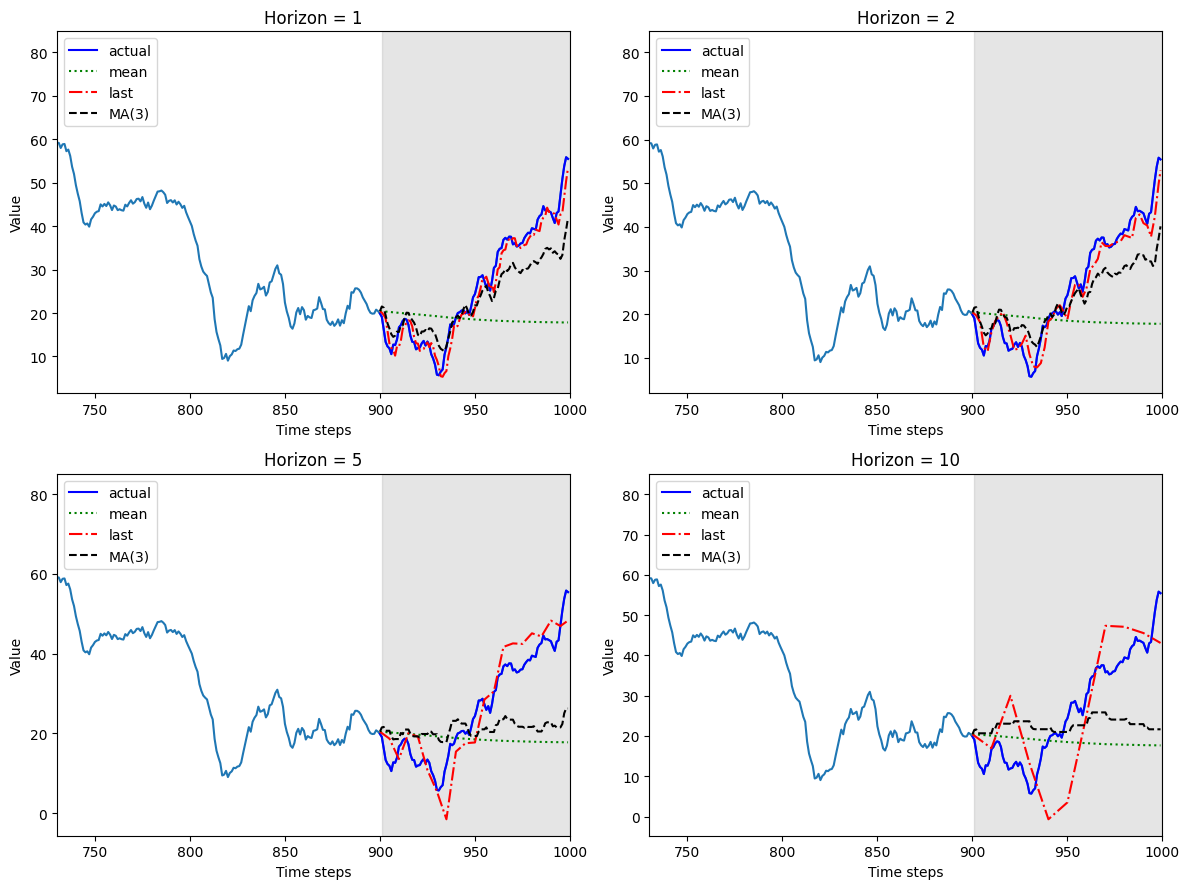

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(df['value'])
    ax.plot(pred_df['value'], 'b-', label='actual')
    ax.plot(pred_df[f'pred_mean_{windows[i]}'], 'g:', label='mean')
    ax.plot(pred_df[f'pred_last_{windows[i]}'], 'r-.', label='last')
    ax.plot(pred_df[f'pred_MA_{windows[i]}'], 'k--', label='MA(3)')
    
    ax.legend(loc=2)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.axvspan(901, 1000, color='#808080', alpha=0.2)
    ax.set_xlim(730, 1000)
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

In [26]:
from sklearn.metrics import mean_absolute_error

mae_mean_1 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_1'])
mae_last_1 = mean_absolute_error(pred_df['value'], pred_df['pred_last_1'])
mae_MA_1 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_1'])

mae_mean_2 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_2'])
mae_last_2 = mean_absolute_error(pred_df['value'], pred_df['pred_last_2'])
mae_MA_2 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_2'])

mae_mean_5 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_5'])
mae_last_5 = mean_absolute_error(pred_df['value'], pred_df['pred_last_5'])
mae_MA_5 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_5'])

mae_mean_10 = mean_absolute_error(pred_df['value'], pred_df['pred_mean_10'])
mae_last_10 = mean_absolute_error(pred_df['value'], pred_df['pred_last_10'])
mae_MA_10 = mean_absolute_error(pred_df['value'], pred_df['pred_MA_10'])

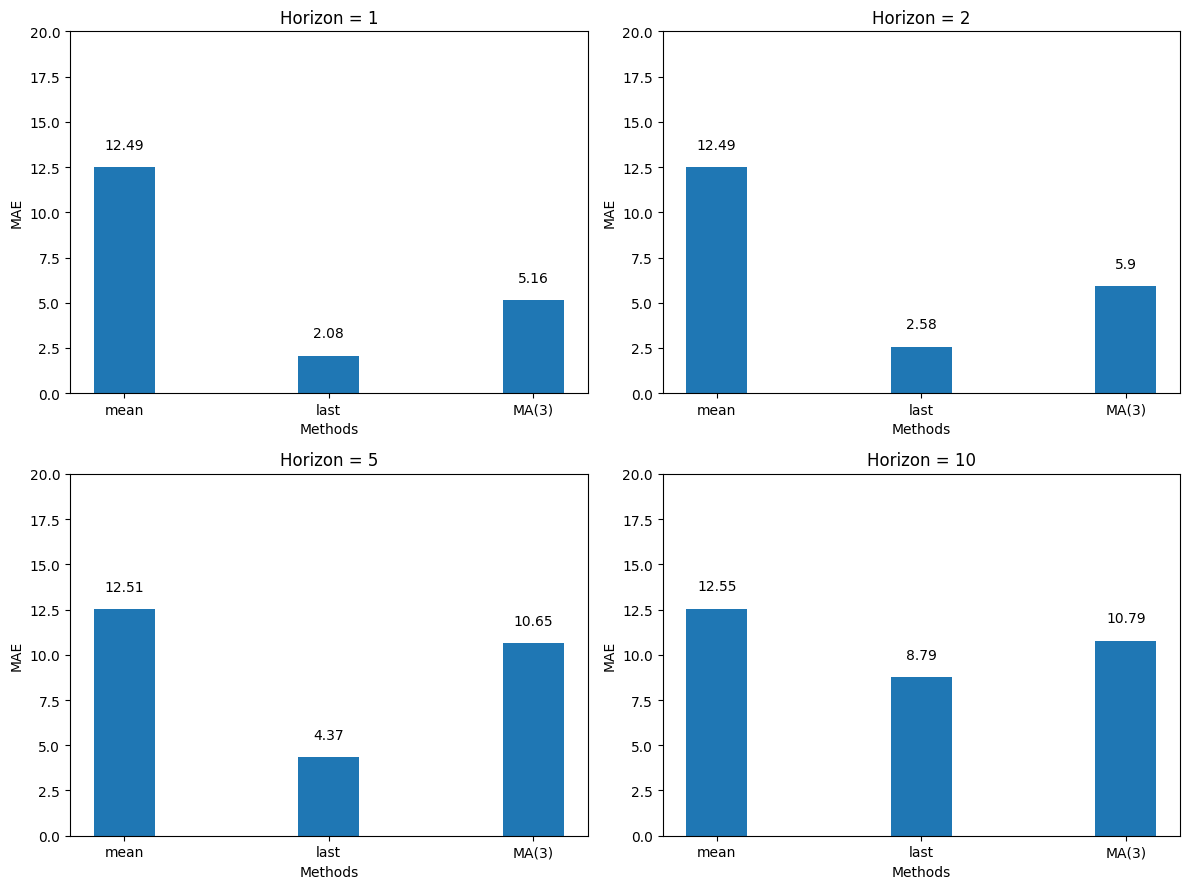

In [27]:
maes_mean = [mae_mean_1, mae_mean_2, mae_mean_5, mae_mean_10]
maes_last = [mae_last_1, mae_last_2, mae_last_5, mae_last_10]
maes_MA = [mae_MA_1, mae_MA_2, mae_MA_5, mae_MA_10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

x = ['mean', 'last', 'MA(3)']
width = 0.3

for i, ax in enumerate(axes.flatten()):
    
    y = [maes_mean[i], maes_last[i], maes_MA[i]]
    ax.bar(x, y, width)
    ax.set_xlabel('Methods')
    ax.set_ylabel('MAE')
    ax.set_ylim(0, 20)
    ax.set_title(f'Horizon = {windows[i]}')    
    
    for index, value in enumerate(y):
        ax.text(x=index, y=value+1, s=str(round(value, 2)), ha='center')

plt.tight_layout()